# MACD Momentum Strategy: Deep Dive with Backtrader

**December 15, 2024 • Karthik Bibireddy (AI Generated Text)**

![MACD Indicator Chart](https://images.unsplash.com/photo-1590283603385-17ffb3a7f29f?w=800&h=400&fit=crop)

## Overview

The MACD (Moving Average Convergence Divergence) Momentum Strategy is a sophisticated technical analysis approach for capturing mid-term trend accelerations over 3-6 week periods. This strategy uses momentum shifts and signal line crossovers to identify optimal entry and exit points in trending markets.

This notebook provides a comprehensive deep dive using **backtrader**, a professional backtesting framework:
- Mathematical foundations of MACD
- Strategy implementation using backtrader
- Real-world backtesting on multiple tickers
- Performance comparison: Baseline ETFs vs Individual Stocks
- Comprehensive visualizations for novice traders

## Table of Contents

1. [Setup and Imports](#setup)
2. [Mathematical Foundations](#mathematical-foundations)
3. [Understanding MACD](#understanding-macd)
4. [Strategy Implementation with Backtrader](#strategy-implementation)
5. [Data Loading and Preparation](#data-loading)
6. [Backtesting on Baseline Tickers](#baseline-backtest)
7. [Performance Comparison](#performance-comparison)
8. [Visual Analysis](#visual-analysis)
9. [Key Takeaways](#key-takeaways)

## 1. Setup and Imports {#setup}

First, let's install and import all necessary libraries.

In [14]:
# Install backtrader if not already installed
# !pip install backtrader matplotlib pandas numpy

## 2. Mathematical Foundations {#mathematical-foundations}

### MACD Formula

MACD consists of three main components:

1. **MACD Line**: Fast EMA minus Slow EMA
   - MACD Line = EMA(12) - EMA(26)

2. **Signal Line**: EMA of MACD Line
   - Signal Line = EMA(9) of MACD Line

3. **Histogram**: Difference between MACD and Signal Line
   - Histogram = MACD Line - Signal Line

### Exponential Moving Average (EMA)

EMA gives more weight to recent prices:

$$EMA_{today} = (Price_{today} \times K) + (EMA_{yesterday} \times (1 - K))$$

Where $K = \frac{2}{Period + 1}$ (smoothing factor)

For a 12-period EMA: $K = \frac{2}{13} = 0.1538$

### Trading Signals

- **Bullish Crossover**: MACD Line crosses above Signal Line (buy signal)
- **Bearish Crossover**: MACD Line crosses below Signal Line (sell signal)
- **Zero Line Crossover**: MACD Line crosses above/below zero (trend confirmation)
- **Histogram**: Visual representation of momentum strength

### Exponential Moving Average (EMA): Calculation, Advantages, and Smoothing Factor

Before diving into MACD, it's essential to understand the **Exponential Moving Average (EMA)**—the fundamental building block of the MACD indicator. This section provides a comprehensive explanation of how EMA is calculated, why it's superior to Simple Moving Average (SMA) for momentum analysis, and the critical role of the smoothing factor.

#### What is EMA?

The Exponential Moving Average (EMA) is a type of moving average that applies **exponentially decaying weights** to historical prices, giving more importance to recent data points. Unlike Simple Moving Average (SMA), which treats all prices equally, EMA creates a geometric progression of weights that exponentially favor recent prices.

#### Mathematical Formulation

The recursive formula for EMA is:

```
EMA(t) = α × Price(t) + (1 - α) × EMA(t-1)
```

Where:
- **α (alpha)** = smoothing factor = `2 / (N + 1)`
- **N** = period (e.g., 12 or 26 for MACD)
- **EMA(t-1)** = previous EMA value
- **Price(t)** = current price

**Key Insight**: The smoothing factor α determines how much weight is given to the current price versus the historical EMA. For a 12-period EMA, α = 2/13 ≈ 0.1538, meaning the current price gets 15.38% weight, while the previous EMA (which contains all historical information) gets 84.62% weight.

#### Why the Smoothing Factor α = 2/(N+1)?

The smoothing factor formula `α = 2/(N+1)` is not arbitrary—it's designed to create a specific mathematical relationship:

1. **Effective Period Matching**: This formula ensures that an N-period EMA has approximately the same "center of mass" as an N-period SMA. The factor 2 ensures that approximately 86.47% of the EMA's weight comes from the last N periods.

2. **Geometric Progression**: The formula creates a geometric series where weights decrease exponentially:
   - Most recent price: α weight
   - Previous price: α(1-α) weight  
   - Two periods ago: α(1-α)² weight
   - And so on...

3. **Mathematical Elegance**: The infinite sum of these weights converges to 1, ensuring the EMA is properly normalized.

**Derivation**: If we expand the recursive formula:
```
EMA(t) = α × Price(t) + (1-α) × EMA(t-1)
       = α × Price(t) + (1-α) × [α × Price(t-1) + (1-α) × EMA(t-2)]
       = α × Price(t) + α(1-α) × Price(t-1) + (1-α)² × EMA(t-2)
       = α × Price(t) + α(1-α) × Price(t-1) + α(1-α)² × Price(t-2) + ...
```

This shows that EMA is a weighted average where weights follow: `w₀ = α`, `w₁ = α(1-α)`, `w₂ = α(1-α)²`, etc.

#### Advantages of EMA over SMA

**1. Faster Response to Price Changes**

EMA responds more quickly to recent price movements because it gives exponentially more weight to recent prices. This makes EMA ideal for momentum indicators like MACD, where detecting trend changes early is crucial.

**Mathematical Comparison**:
- **SMA**: All N prices get equal weight (1/N each)
- **EMA**: Recent prices get exponentially more weight

**2. Reduced Lag**

SMA has inherent lag because it waits for old prices to "drop out" of the window. EMA continuously adapts, reducing lag while still smoothing noise.

**3. Memory Effect**

EMA maintains a "memory" of all historical prices (through the recursive formula), but with exponentially decaying influence. This provides:
- Better trend following in trending markets
- Smoother transitions during trend changes
- More stable signals than SMA

**4. Better Signal Quality**

For momentum analysis, EMA provides:
- Earlier trend change detection
- Less whipsaw in sideways markets (due to smoothing)
- More reliable crossover signals

**Practical Example**: If a stock price suddenly jumps 10%, a 12-period EMA will respond faster than a 12-period SMA because the EMA immediately incorporates the new price with 15.38% weight, while SMA must wait for 11 more periods before the old price fully "drops out."

#### Initialization: The First EMA Value

The recursive EMA formula requires an initial value. The standard approach is:

1. **SMA Initialization**: Calculate SMA for the first N periods
2. **EMA Continuation**: Use the recursive formula for all subsequent periods

```
EMA(N-1) = SMA(N) = (Price(0) + Price(1) + ... + Price(N-1)) / N
EMA(N) = α × Price(N) + (1-α) × EMA(N-1)
```

This ensures the EMA starts with a stable baseline before applying exponential weighting.

#### The Smoothing Factor in Practice

The smoothing factor α controls the trade-off between responsiveness and smoothness:

- **Higher α (shorter period)**: More responsive, more sensitive to price changes, but potentially more noisy
- **Lower α (longer period)**: Smoother, less noisy, but slower to respond to trend changes

**For MACD specifically**:
- **Fast EMA (12-period)**: α₁₂ = 2/13 ≈ 0.1538 → 15.38% weight to current price
- **Slow EMA (26-period)**: α₂₆ = 2/27 ≈ 0.0741 → 7.41% weight to current price

The fast EMA is approximately **2.08x more responsive** than the slow EMA, creating the momentum differential that MACD exploits.

#### Why EMA is Essential for MACD

MACD relies on the **difference** between fast and slow EMAs to detect momentum changes. This difference is only meaningful because:

1. **EMA's exponential weighting** ensures recent price changes have significant impact
2. **Different smoothing factors** (α₁₂ vs α₂₆) create a measurable momentum differential
3. **Reduced lag** allows MACD to detect trend changes earlier than SMA-based indicators

If MACD used SMA instead of EMA, the momentum signals would be:
- Slower to detect trend changes
- Less sensitive to recent price action
- More prone to false signals due to equal weighting of old and new prices

In the following sections, we'll see practical code examples and visualizations that demonstrate these concepts.

In [ ]:
# Practical Example: EMA vs SMA Comparison
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_sma(prices, period):
    """Calculate Simple Moving Average"""
    return pd.Series(prices).rolling(window=period).mean().values

def calculate_ema(prices, period):
    """Calculate Exponential Moving Average"""
    alpha = 2 / (period + 1)
    ema = np.zeros_like(prices, dtype=float)
    
    # Initialize with SMA
    ema[period-1] = np.mean(prices[:period])
    
    # Calculate recursively
    for i in range(period, len(prices)):
        ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
    
    return ema

# Generate sample price data with a trend change
np.random.seed(42)
days = np.arange(60)
base_price = 100

# Create price data: stable, then sudden trend change
prices = base_price + np.cumsum(np.random.randn(60) * 0.5)
prices[30:] += np.linspace(0, 15, 30)  # Add upward trend starting at day 30

# Calculate moving averages
period = 12
sma_12 = calculate_sma(prices, period)
ema_12 = calculate_ema(prices, period)

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Price with SMA and EMA overlay
ax1 = axes[0]
ax1.plot(days, prices, 'ko-', markersize=4, linewidth=1.5, label='Price', alpha=0.7)
ax1.plot(days[period-1:], sma_12[period-1:], 'r--', linewidth=2, label=f'SMA({period})', alpha=0.8)
ax1.plot(days[period-1:], ema_12[period-1:], 'b-', linewidth=2.5, label=f'EMA({period})', alpha=0.9)
ax1.axvline(x=30, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Trend Change')
ax1.set_xlabel('Days', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title(f'EMA vs SMA: Response to Trend Change\n(Period = {period})', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Highlight the difference
difference = ema_12[period-1:] - sma_12[period-1:]
ax2 = axes[1]
ax2.plot(days[period-1:], difference, 'g-', linewidth=2.5, label='EMA - SMA')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax2.axvline(x=30, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Trend Change')
ax2.fill_between(days[period-1:], 0, difference, where=(difference >= 0), 
                 alpha=0.3, color='green', label='EMA leads SMA')
ax2.fill_between(days[period-1:], 0, difference, where=(difference < 0), 
                 alpha=0.3, color='red', label='EMA lags SMA')
ax2.set_xlabel('Days', fontsize=12, fontweight='bold')
ax2.set_ylabel('Difference (EMA - SMA)', fontsize=12, fontweight='bold')
ax2.set_title('EMA Response Advantage: EMA Leads SMA After Trend Changes', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("=" * 70)
print("KEY INSIGHTS: EMA vs SMA")
print("=" * 70)
print(f"\n1. Response Speed:")
print(f"   - EMA responds faster to trend changes (visible after day 30)")
print(f"   - SMA lags behind due to equal weighting of all prices")
print(f"\n2. Maximum Difference: {np.max(np.abs(difference)):.4f}")
print(f"   - This represents how much EMA leads/lags SMA")
print(f"\n3. After Trend Change (Day 30+):")
print(f"   - EMA immediately starts rising with new trend")
print(f"   - SMA takes longer to reflect the trend change")
print(f"\n4. Why EMA is Better for MACD:")
print(f"   - Faster momentum detection = earlier trading signals")
print(f"   - Reduced lag = better entry/exit timing")
print("=" * 70)

In [ ]:
# Visualization: Understanding the Smoothing Factor α

def visualize_smoothing_factor():
    """
    Comprehensive visualization of EMA smoothing factor and weight distribution
    """
    periods = 50
    fast_period = 12
    slow_period = 26
    
    # Calculate smoothing factors
    alpha_fast = 2 / (fast_period + 1)
    alpha_slow = 2 / (slow_period + 1)
    
    # Calculate weights for each lag (how much each historical price contributes)
    lags = np.arange(0, periods)
    weights_fast = alpha_fast * ((1 - alpha_fast) ** lags)
    weights_slow = alpha_slow * ((1 - alpha_slow) ** lags)
    
    # Normalize weights (they should sum to ~1 for infinite series)
    weights_fast = weights_fast / weights_fast.sum()
    weights_slow = weights_slow / weights_slow.sum()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Weight distribution over time (Exponential Decay)
    ax1 = axes[0, 0]
    ax1.plot(lags, weights_fast * 100, 'b-', linewidth=2.5, 
             label=f'Fast EMA ({fast_period}-period, α={alpha_fast:.4f})', marker='o', markersize=4)
    ax1.plot(lags, weights_slow * 100, 'r-', linewidth=2.5, 
             label=f'Slow EMA ({slow_period}-period, α={alpha_slow:.4f})', marker='s', markersize=4)
    ax1.axvline(x=fast_period, color='b', linestyle='--', alpha=0.5, linewidth=2, 
                label=f'{fast_period}-period mark')
    ax1.axvline(x=slow_period, color='r', linestyle='--', alpha=0.5, linewidth=2, 
                label=f'{slow_period}-period mark')
    ax1.set_xlabel('Days Ago (Lag)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Weight (%)', fontsize=12, fontweight='bold')
    ax1.set_title('EMA Weight Distribution: Exponential Decay\n(How much each historical price contributes)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, periods)
    
    # Add annotation for current price weight
    ax1.annotate(f'Current price: {weights_fast[0]*100:.2f}%', 
                xy=(0, weights_fast[0]*100), xytext=(5, weights_fast[0]*100+2),
                fontsize=10, fontweight='bold', color='blue',
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
    ax1.annotate(f'Current price: {weights_slow[0]*100:.2f}%', 
                xy=(0, weights_slow[0]*100), xytext=(5, weights_slow[0]*100-2),
                fontsize=10, fontweight='bold', color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    # Plot 2: Cumulative weight distribution
    ax2 = axes[0, 1]
    cumulative_fast = np.cumsum(weights_fast) * 100
    cumulative_slow = np.cumsum(weights_slow) * 100
    ax2.plot(lags, cumulative_fast, 'b-', linewidth=2.5, 
             label=f'Fast EMA ({fast_period}-period)', marker='o', markersize=3)
    ax2.plot(lags, cumulative_slow, 'r-', linewidth=2.5, 
             label=f'Slow EMA ({slow_period}-period)', marker='s', markersize=3)
    ax2.axhline(y=86.47, color='gray', linestyle='--', alpha=0.7, linewidth=2, 
                label='86.47% (effective length threshold)')
    ax2.axvline(x=fast_period, color='b', linestyle=':', alpha=0.5)
    ax2.axvline(x=slow_period, color='r', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Days Ago (Lag)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumulative Weight (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Weight Distribution\n(Effective EMA length ≈ 86.47% of weight)', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, periods)
    ax2.set_ylim(0, 105)
    
    # Plot 3: EMA calculation with price data
    ax3 = axes[1, 0]
    # Generate sample price data
    np.random.seed(42)
    sample_prices = 100 + np.cumsum(np.random.randn(40) * 2)
    sample_days = np.arange(len(sample_prices))
    
    # Calculate EMA
    ema_fast_calc = calculate_ema(sample_prices, fast_period)
    ema_slow_calc = calculate_ema(sample_prices, slow_period)
    sma_fast_calc = calculate_sma(sample_prices, fast_period)
    
    ax3.plot(sample_days, sample_prices, 'ko-', markersize=5, linewidth=1.5, 
             label='Price', alpha=0.7)
    ax3.plot(sample_days[fast_period-1:], ema_fast_calc[fast_period-1:], 
             'b-', linewidth=2.5, label=f'Fast EMA ({fast_period})')
    ax3.plot(sample_days[slow_period-1:], ema_slow_calc[slow_period-1:], 
             'r-', linewidth=2.5, label=f'Slow EMA ({slow_period})')
    ax3.plot(sample_days[fast_period-1:], sma_fast_calc[fast_period-1:], 
             'g--', linewidth=2, label=f'SMA ({fast_period})', alpha=0.7)
    ax3.axvspan(0, fast_period-1, alpha=0.1, color='blue', label='EMA initialization')
    ax3.axvspan(0, slow_period-1, alpha=0.1, color='red')
    ax3.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax3.set_title('EMA Calculation: Price vs Moving Averages\n(Shows EMA lag, smoothing, and responsiveness)', 
                  fontsize=14, fontweight='bold')
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Smoothing factor α as a function of period N
    ax4 = axes[1, 1]
    periods_range = np.arange(5, 51)
    alphas = 2 / (periods_range + 1)
    ax4.plot(periods_range, alphas * 100, 'g-', linewidth=3, label='α = 2/(N+1)')
    ax4.axvline(x=fast_period, color='b', linestyle='--', linewidth=2.5, 
                label=f'Fast EMA (α={alpha_fast:.4f})')
    ax4.axvline(x=slow_period, color='r', linestyle='--', linewidth=2.5, 
                label=f'Slow EMA (α={alpha_slow:.4f})')
    ax4.scatter([fast_period], [alpha_fast * 100], color='blue', s=200, zorder=5, 
                edgecolors='black', linewidths=2)
    ax4.scatter([slow_period], [alpha_slow * 100], color='red', s=200, zorder=5, 
                edgecolors='black', linewidths=2)
    ax4.set_xlabel('EMA Period (N)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Smoothing Factor α (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Smoothing Factor α = 2/(N+1)\n(Higher α = more responsive, Lower α = smoother)', 
                  fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right', fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    # Add text annotations
    ax4.annotate(f'α={alpha_fast:.4f}\n({alpha_fast*100:.2f}%)', 
                xy=(fast_period, alpha_fast * 100), 
                xytext=(fast_period+3, alpha_fast * 100+1),
                fontsize=10, fontweight='bold', color='blue',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
    ax4.annotate(f'α={alpha_slow:.4f}\n({alpha_slow*100:.2f}%)', 
                xy=(slow_period, alpha_slow * 100), 
                xytext=(slow_period+3, alpha_slow * 100-1),
                fontsize=10, fontweight='bold', color='red',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    plt.tight_layout()
    return fig

# Create the comprehensive visualization
fig_ema = visualize_smoothing_factor()
plt.show()

# Print detailed insights
print("\n" + "=" * 70)
print("DETAILED INSIGHTS: Smoothing Factor and EMA Properties")
print("=" * 70)
print(f"\n1. Smoothing Factor Values:")
print(f"   - Fast EMA (12-period): α = {2/(12+1):.4f} = {2/(12+1)*100:.2f}%")
print(f"   - Slow EMA (26-period): α = {2/(26+1):.4f} = {2/(26+1)*100:.2f}%")
print(f"   - Fast EMA is {2/(12+1)/(2/(26+1)):.2f}x more responsive than Slow EMA")
print(f"\n2. Weight Distribution:")
print(f"   - Current price gets {2/(12+1)*100:.2f}% weight in Fast EMA")
print(f"   - Current price gets {2/(26+1)*100:.2f}% weight in Slow EMA")
print(f"   - Weights decrease exponentially: w(t-k) = α(1-α)ᵏ")
print(f"\n3. Effective Length:")
print(f"   - 86.47% of EMA weight comes from the last N periods")
print(f"   - This is why α = 2/(N+1) creates equivalent 'center of mass' to N-period SMA")
print(f"\n4. Why This Matters for MACD:")
print(f"   - The difference between Fast and Slow EMA captures momentum")
print(f"   - Different α values create measurable momentum differential")
print(f"   - Exponential weighting ensures recent price changes have significant impact")
print("=" * 70 + "\n")

### 2.1 Overview: The MACD Indicator Architecture

MACD (Moving Average Convergence Divergence) is fundamentally a **momentum oscillator** that transforms price data into a normalized indicator through a series of mathematical operations. The indicator consists of three interconnected components:

1. **MACD Line**: The difference between two exponential moving averages (EMAs)
2. **Signal Line**: An EMA of the MACD Line itself
3. **Histogram**: The difference between MACD and Signal lines

The mathematical elegance lies in how these components interact to reveal momentum shifts before they become apparent in raw price action.

**Key Mathematical Insight**: MACD doesn't just track price—it tracks the **rate of change** of price momentum, making it a second-derivative indicator of price action.


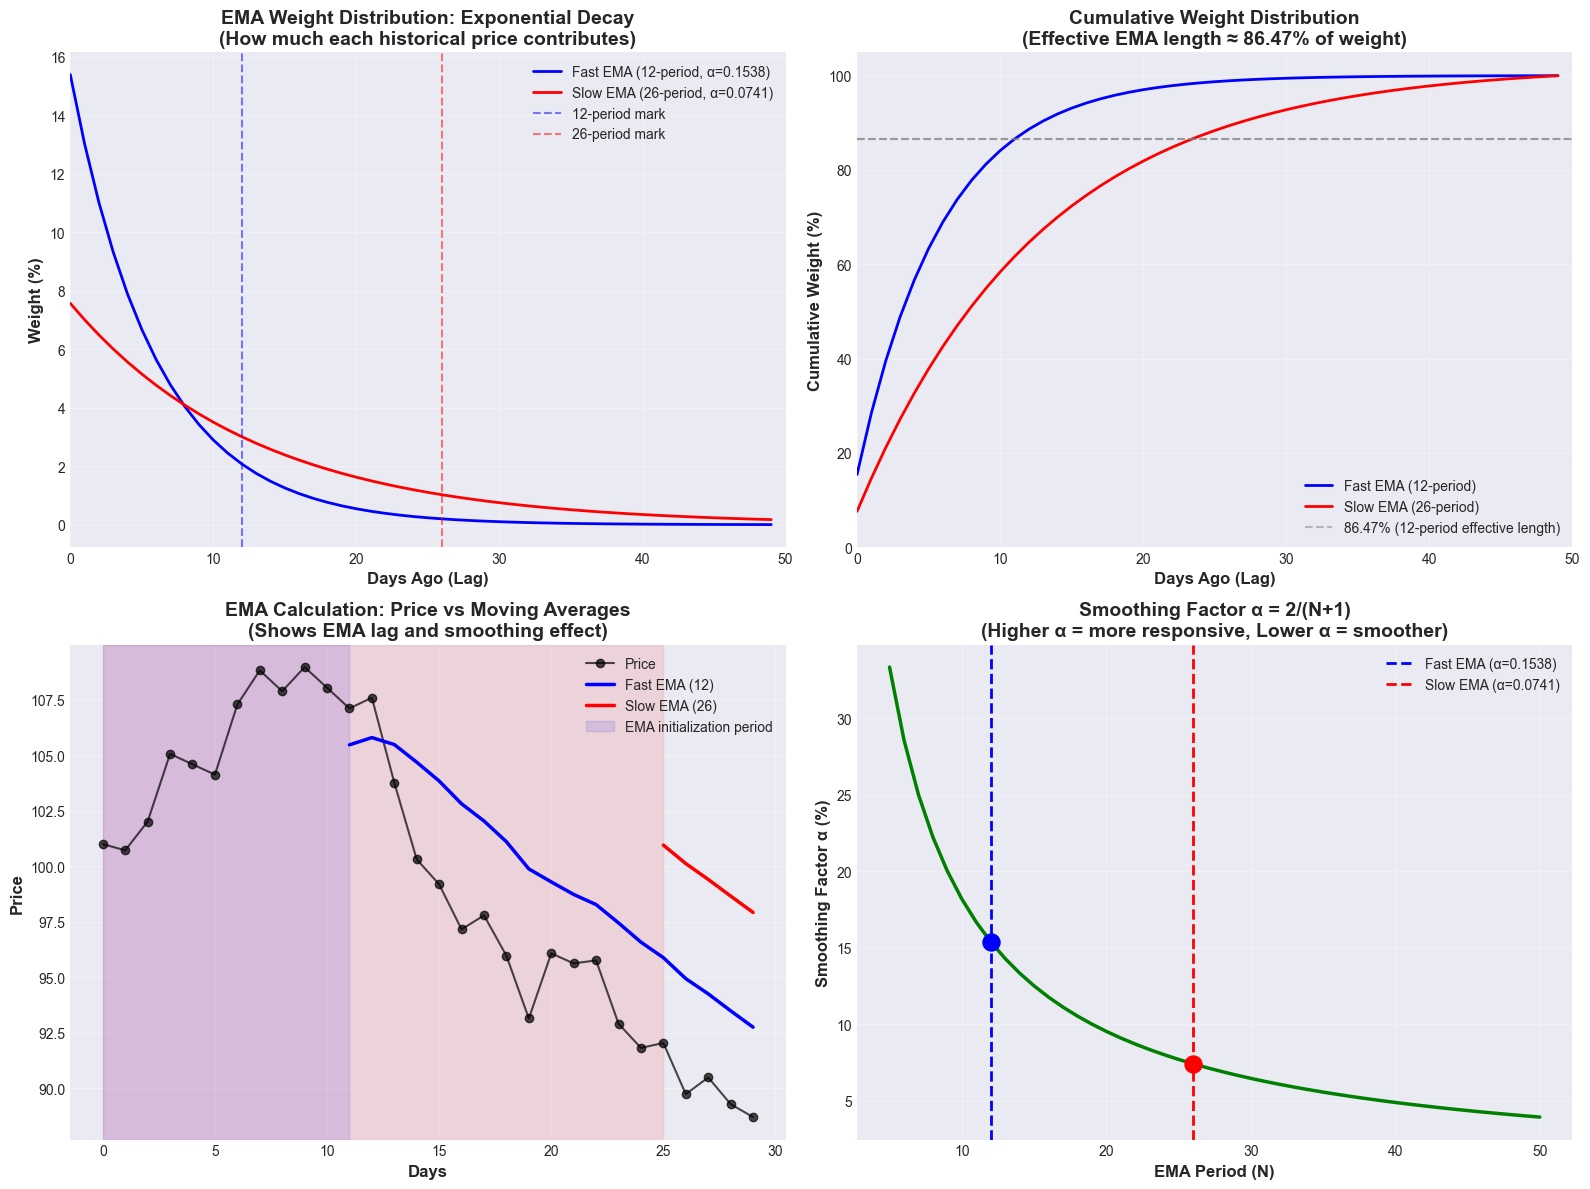

Key Insights:
1. Fast EMA (12-period) has α=0.1538, giving 15.38% weight to current price
2. Slow EMA (26-period) has α=0.0741, giving 7.41% weight to current price
3. Fast EMA is 2.08x more responsive than Slow EMA
4. 86.47% of EMA weight comes from the last N periods (effective length)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Visualize EMA weights and calculation
def visualize_ema_weights():
    """
    Visualize how EMA applies exponentially decaying weights to historical prices.
    """
    periods = 50
    fast_period = 12
    slow_period = 26
    
    # Calculate smoothing factors
    alpha_fast = 2 / (fast_period + 1)
    alpha_slow = 2 / (slow_period + 1)
    
    # Calculate weights for each lag (how much each historical price contributes)
    lags = np.arange(0, periods)
    weights_fast = alpha_fast * ((1 - alpha_fast) ** lags)
    weights_slow = alpha_slow * ((1 - alpha_slow) ** lags)
    
    # Normalize weights (they should sum to ~1 for infinite series)
    weights_fast = weights_fast / weights_fast.sum()
    weights_slow = weights_slow / weights_slow.sum()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Weight distribution over time
    ax1 = axes[0, 0]
    ax1.plot(lags, weights_fast * 100, 'b-', linewidth=2, label=f'Fast EMA ({fast_period}-period, α={alpha_fast:.4f})')
    ax1.plot(lags, weights_slow * 100, 'r-', linewidth=2, label=f'Slow EMA ({slow_period}-period, α={alpha_slow:.4f})')
    ax1.axvline(x=fast_period, color='b', linestyle='--', alpha=0.5, label=f'{fast_period}-period mark')
    ax1.axvline(x=slow_period, color='r', linestyle='--', alpha=0.5, label=f'{slow_period}-period mark')
    ax1.set_xlabel('Days Ago (Lag)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Weight (%)', fontsize=12, fontweight='bold')
    ax1.set_title('EMA Weight Distribution: Exponential Decay\n(How much each historical price contributes)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, periods)
    
    # Plot 2: Cumulative weight (how much of total weight is accounted for)
    ax2 = axes[0, 1]
    cumulative_fast = np.cumsum(weights_fast) * 100
    cumulative_slow = np.cumsum(weights_slow) * 100
    ax2.plot(lags, cumulative_fast, 'b-', linewidth=2, label=f'Fast EMA ({fast_period}-period)')
    ax2.plot(lags, cumulative_slow, 'r-', linewidth=2, label=f'Slow EMA ({slow_period}-period)')
    ax2.axhline(y=86.47, color='gray', linestyle='--', alpha=0.5, label='86.47% (12-period effective length)')
    ax2.axhline(y=86.47, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Days Ago (Lag)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumulative Weight (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Weight Distribution\n(Effective EMA length ≈ 86.47% of weight)', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, periods)
    ax2.set_ylim(0, 105)
    
    # Plot 3: Step-by-step EMA calculation visualization
    ax3 = axes[1, 0]
    # Generate sample price data
    np.random.seed(42)
    sample_prices = 100 + np.cumsum(np.random.randn(30) * 2)
    days = np.arange(len(sample_prices))
    
    # Calculate EMA manually
    def calculate_ema(prices, period):
        alpha = 2 / (period + 1)
        ema = np.zeros_like(prices)
        # Initialize with SMA
        ema[period-1] = np.mean(prices[:period])
        # Calculate recursively
        for i in range(period, len(prices)):
            ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
        return ema
    
    ema_fast = calculate_ema(sample_prices, fast_period)
    ema_slow = calculate_ema(sample_prices, slow_period)
    
    ax3.plot(days, sample_prices, 'ko-', markersize=6, linewidth=1.5, label='Price', alpha=0.7)
    ax3.plot(days[fast_period-1:], ema_fast[fast_period-1:], 'b-', linewidth=2.5, label=f'Fast EMA ({fast_period})')
    ax3.plot(days[slow_period-1:], ema_slow[slow_period-1:], 'r-', linewidth=2.5, label=f'Slow EMA ({slow_period})')
    ax3.axvspan(0, fast_period-1, alpha=0.1, color='blue', label='EMA initialization period')
    ax3.axvspan(0, slow_period-1, alpha=0.1, color='red')
    ax3.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax3.set_title('EMA Calculation: Price vs Moving Averages\n(Shows EMA lag and smoothing effect)', 
                  fontsize=14, fontweight='bold')
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Alpha (smoothing factor) comparison
    ax4 = axes[1, 1]
    periods_range = np.arange(5, 51)
    alphas = 2 / (periods_range + 1)
    ax4.plot(periods_range, alphas * 100, 'g-', linewidth=2.5)
    ax4.axvline(x=fast_period, color='b', linestyle='--', linewidth=2, label=f'Fast EMA (α={alpha_fast:.4f})')
    ax4.axvline(x=slow_period, color='r', linestyle='--', linewidth=2, label=f'Slow EMA (α={alpha_slow:.4f})')
    ax4.scatter([fast_period], [alpha_fast * 100], color='blue', s=150, zorder=5)
    ax4.scatter([slow_period], [alpha_slow * 100], color='red', s=150, zorder=5)
    ax4.set_xlabel('EMA Period (N)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Smoothing Factor α (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Smoothing Factor α = 2/(N+1)\n(Higher α = more responsive, Lower α = smoother)', 
                  fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right', fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create the visualization
fig_ema = visualize_ema_weights()
plt.show()

print("Key Insights:")
print(f"1. Fast EMA (12-period) has α={2/(12+1):.4f}, giving {2/(12+1)*100:.2f}% weight to current price")
print(f"2. Slow EMA (26-period) has α={2/(26+1):.4f}, giving {2/(26+1)*100:.2f}% weight to current price")
print(f"3. Fast EMA is {2/(12+1)/(2/(26+1)):.2f}x more responsive than Slow EMA")
print(f"4. 86.47% of EMA weight comes from the last N periods (effective length)")


### 2.3 The MACD Line: Momentum Extraction

The MACD Line is the **core innovation** of the indicator. It represents the difference between fast and slow EMAs, extracting momentum information.

#### 2.3.1 Mathematical Definition

```
MACD(t) = EMA₁₂(t) - EMA₂₆(t)
```

Where:
- `EMA₁₂(t)` = 12-period exponential moving average at time t
- `EMA₂₆(t)` = 26-period exponential moving average at time t

#### 2.3.2 What Does MACD Line Represent?

The MACD line measures the **rate of change** of momentum:

1. **Positive MACD**: Fast EMA > Slow EMA
   - Recent prices are rising faster than longer-term trend
   - Indicates **accelerating upward momentum**

2. **Negative MACD**: Fast EMA < Slow EMA
   - Recent prices are falling faster than longer-term trend
   - Indicates **accelerating downward momentum**

3. **Zero Crossover**: EMA₁₂ = EMA₂₆
   - Moment of equilibrium between short and long-term trends
   - Potential trend reversal point

#### 2.3.3 Mathematical Properties

**Property 1: Sensitivity to Momentum Changes**
- When price accelerates, Fast EMA responds quickly, Slow EMA lags
- MACD value increases/decreases proportionally to acceleration rate

**Property 2: Normalization**
- MACD is denominated in price units (e.g., dollars)
- Magnitude depends on absolute price level
- Crossovers are more reliable than absolute values

**Property 3: Lag Structure**
- MACD requires 26 periods minimum (wait for Slow EMA initialization)
- Initial 25 values are undefined or use approximations


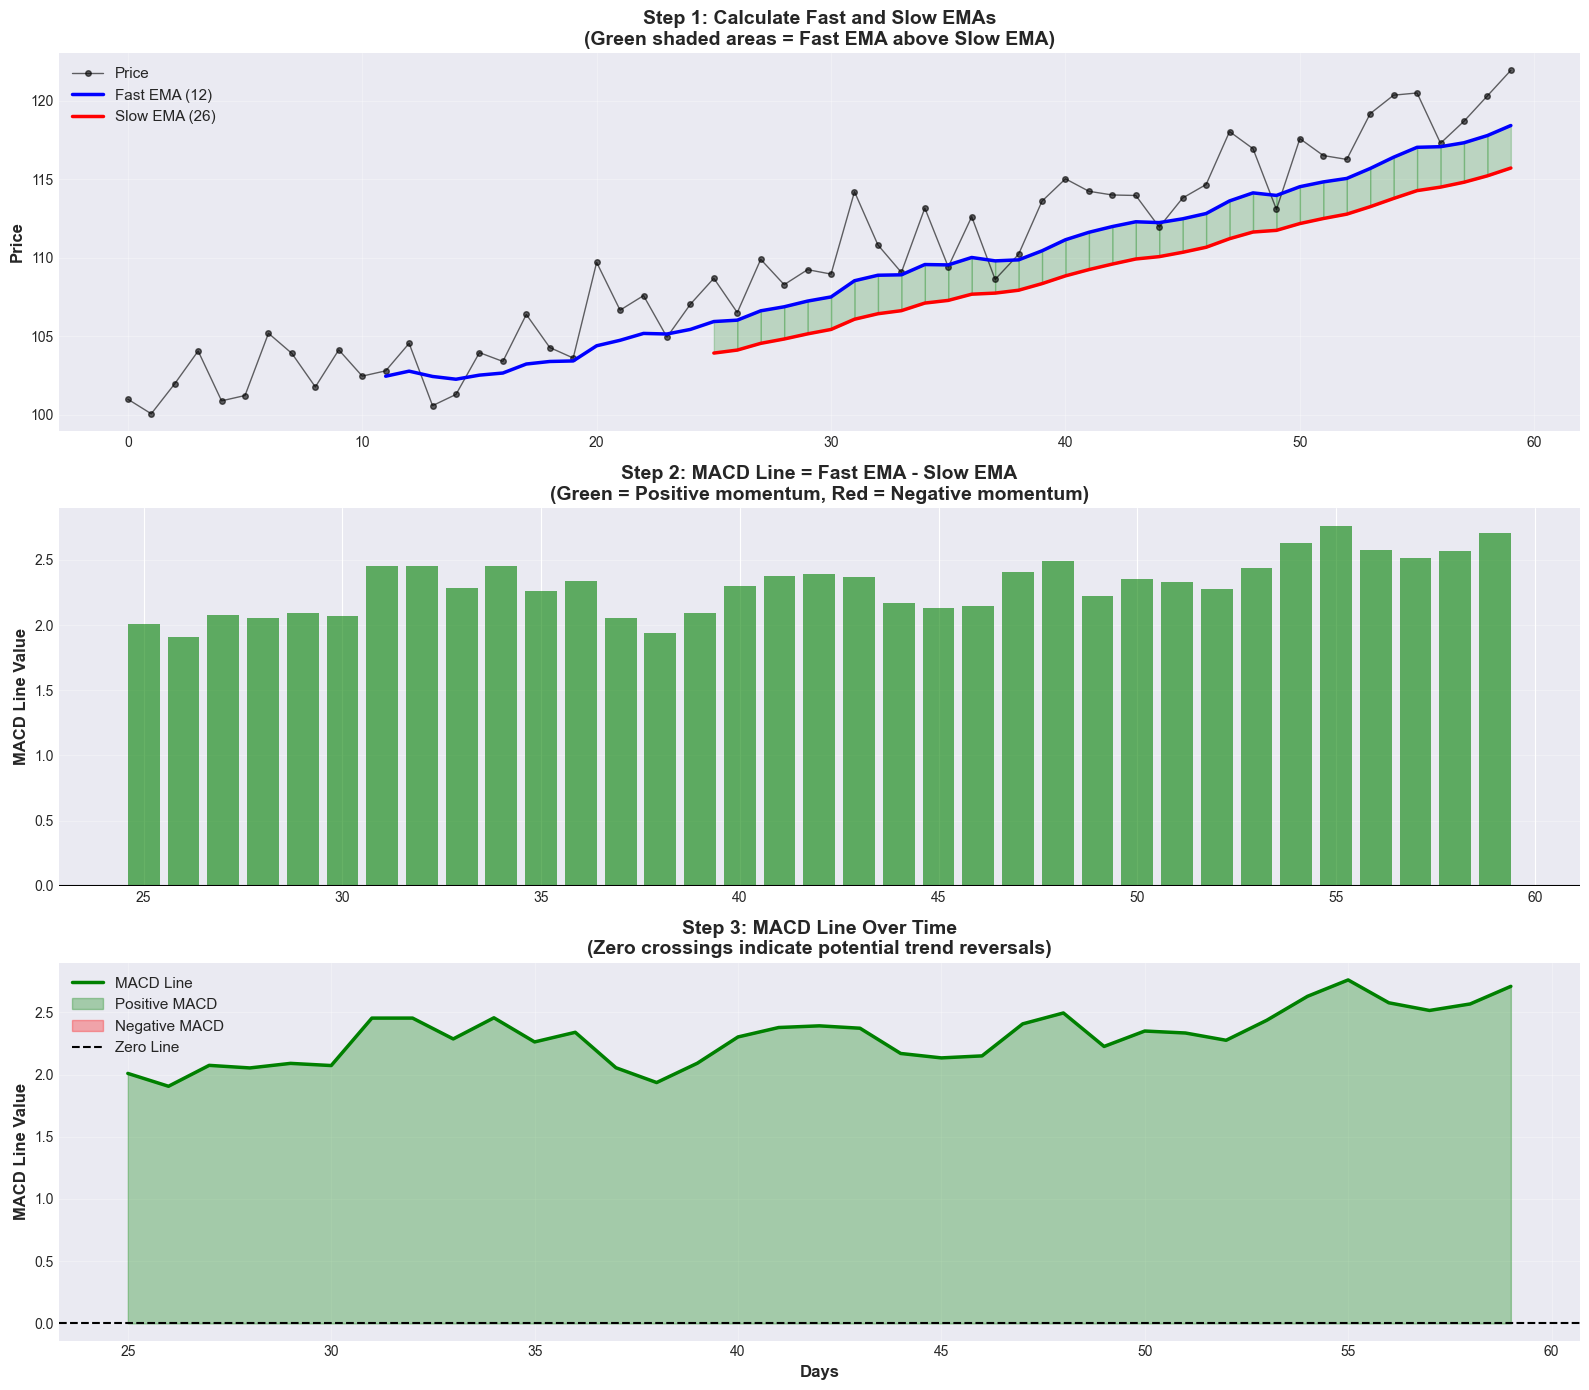


Key Mathematical Insights:
1. MACD Line = EMA₁₂ - EMA₂₆ (difference of two EMAs)
2. Positive MACD → Fast EMA > Slow EMA → Accelerating upward momentum
3. Negative MACD → Fast EMA < Slow EMA → Accelerating downward momentum
4. Zero crossings occur when Fast EMA = Slow EMA (equilibrium point)
5. The magnitude of MACD indicates the strength of momentum divergence


In [16]:
# Visualize MACD Line calculation and its relationship to EMAs
def visualize_macd_line_derivation():
    """
    Demonstrate how MACD Line is derived from Fast and Slow EMAs.
    """
    np.random.seed(42)
    # Generate realistic price data (trending with noise)
    n_periods = 60
    trend = np.linspace(100, 120, n_periods)
    noise = np.random.randn(n_periods) * 2
    prices = trend + noise
    
    fast_period = 12
    slow_period = 26
    
    # Calculate EMAs
    def calculate_ema(prices, period):
        alpha = 2 / (period + 1)
        ema = np.zeros_like(prices)
        ema[period-1] = np.mean(prices[:period])
        for i in range(period, len(prices)):
            ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
        return ema
    
    ema_fast = calculate_ema(prices, fast_period)
    ema_slow = calculate_ema(prices, slow_period)
    
    # Calculate MACD Line
    macd_line = ema_fast - ema_slow
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 14))
    
    # Plot 1: Price and EMAs
    ax1 = axes[0]
    days = np.arange(n_periods)
    ax1.plot(days, prices, 'ko-', markersize=4, linewidth=1, label='Price', alpha=0.6)
    ax1.plot(days[fast_period-1:], ema_fast[fast_period-1:], 'b-', linewidth=2.5, 
             label=f'Fast EMA ({fast_period})')
    ax1.plot(days[slow_period-1:], ema_slow[slow_period-1:], 'r-', linewidth=2.5, 
             label=f'Slow EMA ({slow_period})')
    
    # Highlight areas where Fast > Slow (positive MACD)
    for i in range(slow_period-1, n_periods-1):
        if ema_fast[i] > ema_slow[i]:
            ax1.fill_between([i, i+1], [ema_fast[i], ema_fast[i+1]], 
                            [ema_slow[i], ema_slow[i+1]], alpha=0.2, color='green')
    
    ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax1.set_title('Step 1: Calculate Fast and Slow EMAs\n(Green shaded areas = Fast EMA above Slow EMA)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Visual representation of MACD as difference
    ax2 = axes[1]
    # Show the difference visually using vertical lines
    x_pos = days[slow_period-1:]
    macd_values = macd_line[slow_period-1:]
    colors = ['green' if v > 0 else 'red' for v in macd_values]
    ax2.bar(x_pos, macd_values, color=colors, alpha=0.6, width=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax2.set_ylabel('MACD Line Value', fontsize=12, fontweight='bold')
    ax2.set_title('Step 2: MACD Line = Fast EMA - Slow EMA\n(Green = Positive momentum, Red = Negative momentum)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: MACD Line over time
    ax3 = axes[2]
    ax3.plot(x_pos, macd_values, 'g-', linewidth=2.5, label='MACD Line')
    ax3.fill_between(x_pos, 0, macd_values, where=(macd_values >= 0), 
                     alpha=0.3, color='green', label='Positive MACD')
    ax3.fill_between(x_pos, 0, macd_values, where=(macd_values < 0), 
                     alpha=0.3, color='red', label='Negative MACD')
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1.5, label='Zero Line')
    
    # Mark zero crossings
    zero_crossings = []
    for i in range(1, len(macd_values)):
        if (macd_values[i-1] < 0 and macd_values[i] > 0) or \
           (macd_values[i-1] > 0 and macd_values[i] < 0):
            zero_crossings.append(x_pos[i])
            ax3.axvline(x=x_pos[i], color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    
    if zero_crossings:
        ax3.scatter(zero_crossings, [0]*len(zero_crossings), color='orange', 
                   s=100, zorder=5, label='Zero Crossings', marker='o', edgecolors='black')
    
    ax3.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax3.set_ylabel('MACD Line Value', fontsize=12, fontweight='bold')
    ax3.set_title('Step 3: MACD Line Over Time\n(Zero crossings indicate potential trend reversals)', 
                  fontsize=14, fontweight='bold')
    ax3.legend(loc='best', fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig_macd = visualize_macd_line_derivation()
plt.show()

print("\nKey Mathematical Insights:")
print("=" * 60)
print("1. MACD Line = EMA₁₂ - EMA₂₆ (difference of two EMAs)")
print("2. Positive MACD → Fast EMA > Slow EMA → Accelerating upward momentum")
print("3. Negative MACD → Fast EMA < Slow EMA → Accelerating downward momentum")
print("4. Zero crossings occur when Fast EMA = Slow EMA (equilibrium point)")
print("5. The magnitude of MACD indicates the strength of momentum divergence")


### 2.4 The Signal Line: Momentum Smoothing

The Signal Line is an EMA of the MACD Line itself, creating a **smoothed version** of momentum that filters out noise and provides clearer entry/exit signals.

**Mathematical Definition:**
```
Signal(t) = EMA₉(MACD(t)) = α₉ × MACD(t) + (1 - α₉) × Signal(t-1)
```
Where α₉ = 2/(9+1) = 0.2

**Key Insight**: The Signal Line smooths the MACD Line, creating a baseline for momentum direction. Crossovers represent changes in momentum acceleration.


### 2.5 The Histogram: Momentum Acceleration Indicator

The Histogram is the difference between MACD Line and Signal Line, providing a **second-order derivative** of price momentum.

**Mathematical Definition:**
```
Histogram(t) = MACD(t) - Signal(t)
```

**Mathematical Interpretation:**
- Positive Histogram: MACD > Signal → Momentum is accelerating (faster than smoothed trend)
- Negative Histogram: MACD < Signal → Momentum is decelerating (slower than smoothed trend)
- Zero: MACD = Signal → Crossover point (potential momentum reversal)

**Key Properties:**
1. **Early Warning**: Histogram changes direction before MACD/Signal crossover
2. **Divergence Detection**: When price makes new highs/lows but histogram doesn't
3. **Momentum Strength**: Height of histogram bars indicates momentum intensity


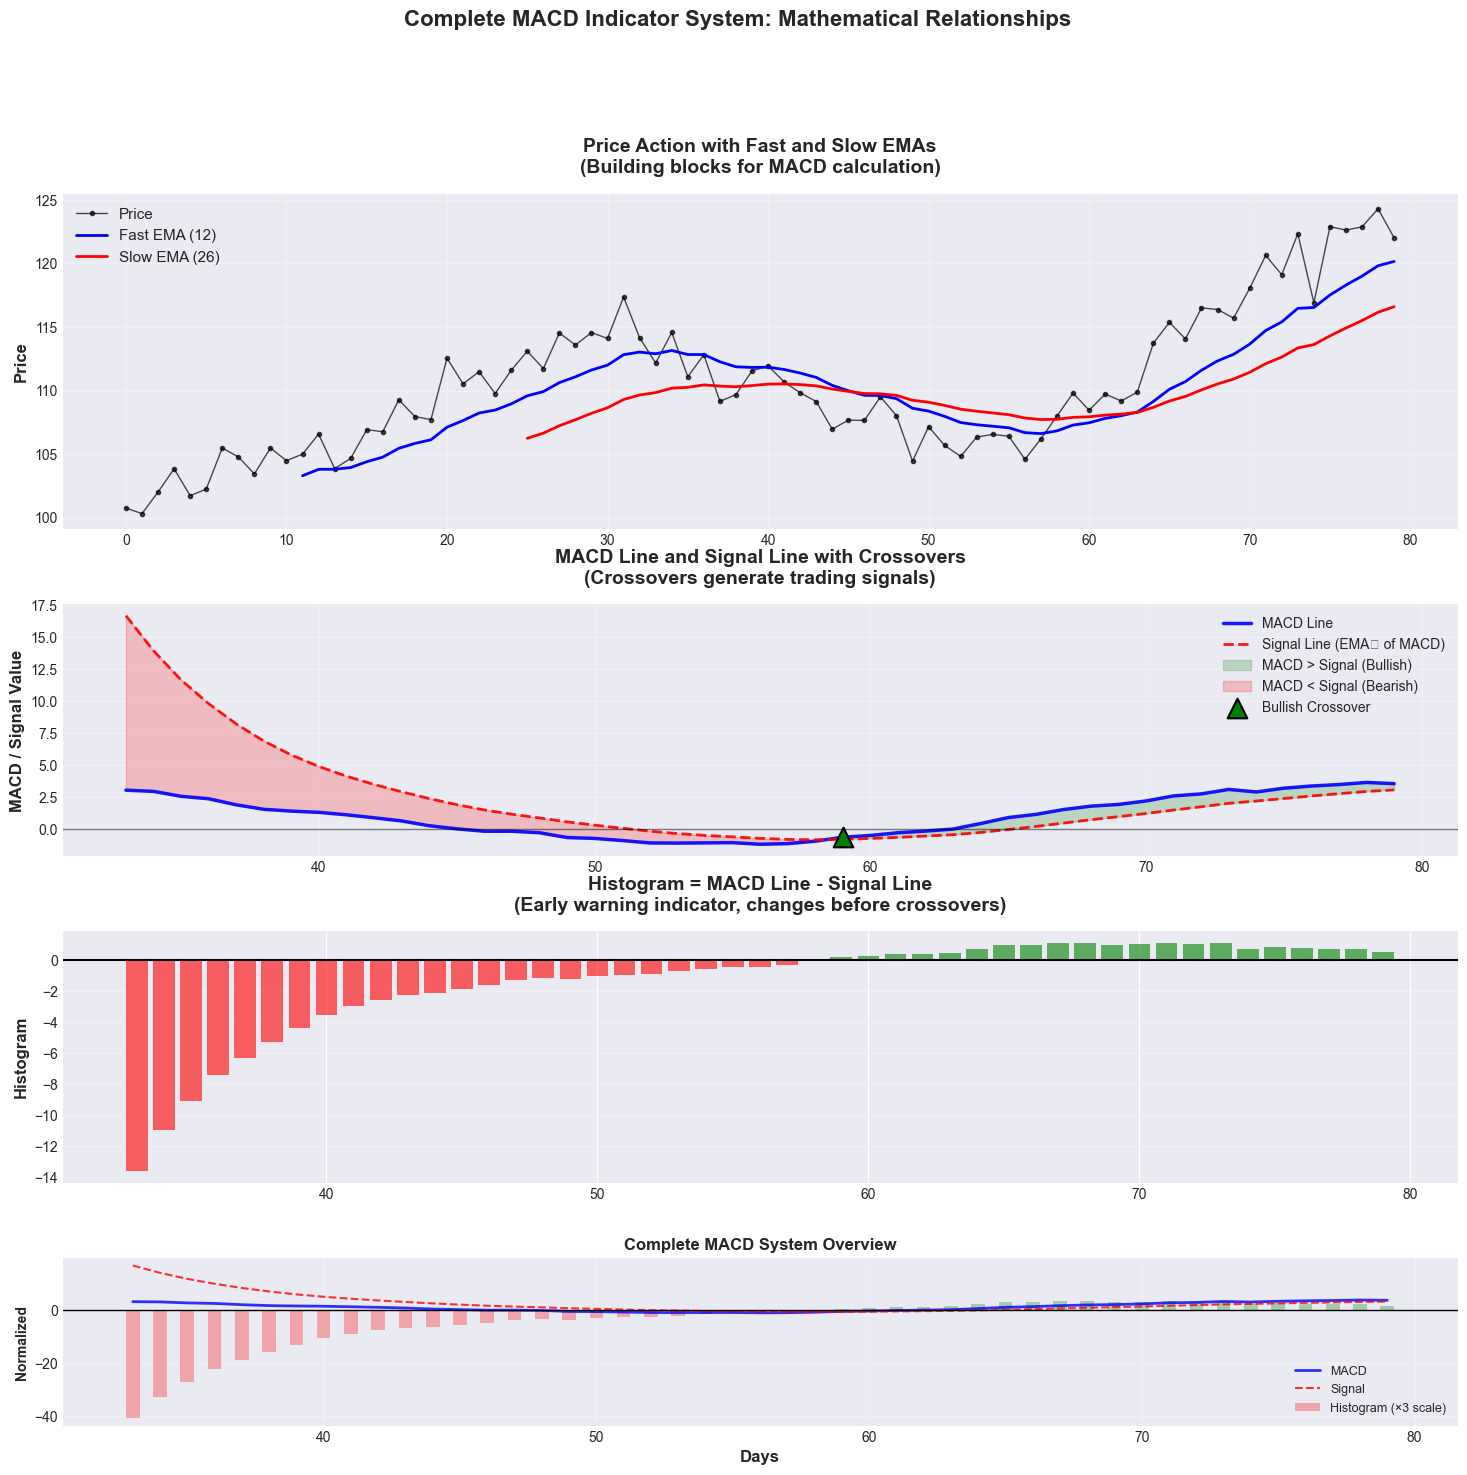


COMPLETE MACD SYSTEM MATHEMATICAL SUMMARY

1. EMA₁₂(t) = α₁₂ × Price(t) + (1-α₁₂) × EMA₁₂(t-1)  where α₁₂ = 2/13 ≈ 0.1538
2. EMA₂₆(t) = α₂₆ × Price(t) + (1-α₂₆) × EMA₂₆(t-1)  where α₂₆ = 2/27 ≈ 0.0741
3. MACD(t) = EMA₁₂(t) - EMA₂₆(t)  [Momentum extraction]
4. Signal(t) = α₉ × MACD(t) + (1-α₉) × Signal(t-1)  where α₉ = 0.2 [Momentum smoothing]
5. Histogram(t) = MACD(t) - Signal(t)  [Acceleration indicator]

Trading Signals:
  • Bullish Crossover: MACD crosses above Signal (buy signal)
  • Bearish Crossover: MACD crosses below Signal (sell signal)
  • Zero Crossover: MACD crosses zero line (trend change confirmation)


In [17]:
# Comprehensive MACD Visualization: All Components Together
def visualize_complete_macd_system():
    """
    Show the complete MACD system: Price, EMAs, MACD Line, Signal Line, and Histogram.
    This demonstrates how all components interact mathematically.
    """
    np.random.seed(42)
    # Generate realistic price data with trend changes
    n_periods = 80
    trend1 = np.linspace(100, 115, 30)
    trend2 = np.linspace(115, 105, 25)
    trend3 = np.linspace(105, 125, 25)
    trend = np.concatenate([trend1, trend2, trend3])
    noise = np.random.randn(n_periods) * 1.5
    prices = trend + noise
    
    fast_period = 12
    slow_period = 26
    signal_period = 9
    
    # Calculate EMAs
    def calculate_ema(prices, period):
        alpha = 2 / (period + 1)
        ema = np.zeros_like(prices)
        ema[period-1] = np.mean(prices[:period])
        for i in range(period, len(prices)):
            ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
        return ema
    
    ema_fast = calculate_ema(prices, fast_period)
    ema_slow = calculate_ema(prices, slow_period)
    
    # Calculate MACD Line
    macd_line = ema_fast - ema_slow
    
    # Calculate Signal Line (EMA of MACD)
    signal_line = calculate_ema(macd_line, signal_period)
    
    # Calculate Histogram
    histogram = macd_line - signal_line
    
    # Valid indices (after initialization)
    valid_start = slow_period + signal_period - 2
    valid_indices = np.arange(valid_start, n_periods)
    
    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(4, 1, height_ratios=[2, 1.5, 1.5, 1], hspace=0.3)
    
    # Plot 1: Price and EMAs
    ax1 = fig.add_subplot(gs[0])
    days = np.arange(n_periods)
    ax1.plot(days, prices, 'ko-', markersize=3, linewidth=1, label='Price', alpha=0.7)
    ax1.plot(days[fast_period-1:], ema_fast[fast_period-1:], 'b-', linewidth=2, label=f'Fast EMA ({fast_period})')
    ax1.plot(days[slow_period-1:], ema_slow[slow_period-1:], 'r-', linewidth=2, label=f'Slow EMA ({slow_period})')
    ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax1.set_title('Price Action with Fast and Slow EMAs\n(Building blocks for MACD calculation)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='best', fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: MACD Line and Signal Line
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(valid_indices, macd_line[valid_indices], 'b-', linewidth=2.5, label='MACD Line', alpha=0.9)
    ax2.plot(valid_indices, signal_line[valid_indices], 'r--', linewidth=2, label='Signal Line (EMA₉ of MACD)', alpha=0.9)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Highlight bullish/bearish regions
    ax2.fill_between(valid_indices, macd_line[valid_indices], signal_line[valid_indices], 
                     where=(macd_line[valid_indices] >= signal_line[valid_indices]),
                     alpha=0.2, color='green', label='MACD > Signal (Bullish)')
    ax2.fill_between(valid_indices, macd_line[valid_indices], signal_line[valid_indices], 
                     where=(macd_line[valid_indices] < signal_line[valid_indices]),
                     alpha=0.2, color='red', label='MACD < Signal (Bearish)')
    
    # Mark crossovers
    crossovers = []
    for i in range(1, len(valid_indices)):
        idx_prev = valid_indices[i-1]
        idx_curr = valid_indices[i]
        if (macd_line[idx_prev] <= signal_line[idx_prev] and macd_line[idx_curr] > signal_line[idx_curr]):
            crossovers.append((idx_curr, 'bullish'))
        elif (macd_line[idx_prev] >= signal_line[idx_prev] and macd_line[idx_curr] < signal_line[idx_curr]):
            crossovers.append((idx_curr, 'bearish'))
    
    for idx, cross_type in crossovers:
        color = 'green' if cross_type == 'bullish' else 'red'
        marker = '^' if cross_type == 'bullish' else 'v'
        ax2.scatter([idx], [macd_line[idx]], color=color, s=200, marker=marker, 
                   zorder=5, edgecolors='black', linewidth=1.5, label=f'{cross_type.title()} Crossover' if idx == crossovers[0][0] else '')
    
    ax2.set_ylabel('MACD / Signal Value', fontsize=12, fontweight='bold')
    ax2.set_title('MACD Line and Signal Line with Crossovers\n(Crossovers generate trading signals)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Histogram
    ax3 = fig.add_subplot(gs[2])
    hist_values = histogram[valid_indices]
    colors_hist = ['green' if v >= 0 else 'red' for v in hist_values]
    ax3.bar(valid_indices, hist_values, color=colors_hist, alpha=0.6, width=0.8)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax3.set_ylabel('Histogram', fontsize=12, fontweight='bold')
    ax3.set_title('Histogram = MACD Line - Signal Line\n(Early warning indicator, changes before crossovers)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Complete system summary (small overview)
    ax4 = fig.add_subplot(gs[3])
    # Show all three on same scale for comparison
    ax4.plot(valid_indices, macd_line[valid_indices], 'b-', linewidth=2, label='MACD', alpha=0.8)
    ax4.plot(valid_indices, signal_line[valid_indices], 'r--', linewidth=1.5, label='Signal', alpha=0.8)
    ax4.bar(valid_indices, hist_values * 3, color=colors_hist, alpha=0.3, width=0.5, label='Histogram (×3 scale)')
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax4.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Normalized', fontsize=10, fontweight='bold')
    ax4.set_title('Complete MACD System Overview', fontsize=12, fontweight='bold')
    ax4.legend(loc='best', fontsize=9, framealpha=0.9)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Complete MACD Indicator System: Mathematical Relationships', 
                 fontsize=16, fontweight='bold', y=0.995)
    return fig

fig_complete = visualize_complete_macd_system()
plt.show()

print("\n" + "="*70)
print("COMPLETE MACD SYSTEM MATHEMATICAL SUMMARY")
print("="*70)
print("\n1. EMA₁₂(t) = α₁₂ × Price(t) + (1-α₁₂) × EMA₁₂(t-1)  where α₁₂ = 2/13 ≈ 0.1538")
print("2. EMA₂₆(t) = α₂₆ × Price(t) + (1-α₂₆) × EMA₂₆(t-1)  where α₂₆ = 2/27 ≈ 0.0741")
print("3. MACD(t) = EMA₁₂(t) - EMA₂₆(t)  [Momentum extraction]")
print("4. Signal(t) = α₉ × MACD(t) + (1-α₉) × Signal(t-1)  where α₉ = 0.2 [Momentum smoothing]")
print("5. Histogram(t) = MACD(t) - Signal(t)  [Acceleration indicator]")
print("\nTrading Signals:")
print("  • Bullish Crossover: MACD crosses above Signal (buy signal)")
print("  • Bearish Crossover: MACD crosses below Signal (sell signal)")
print("  • Zero Crossover: MACD crosses zero line (trend change confirmation)")
print("="*70)


### 2.6 Convergence and Divergence: The Mathematics Behind the Name

The name "Moving Average Convergence Divergence" describes the mathematical behavior of the two EMAs.

#### 2.6.1 Convergence

**Convergence** occurs when the Fast EMA and Slow EMA move toward each other:
- `|EMA₁₂(t) - EMA₂₆(t)|` is decreasing over time
- MACD Line approaches zero
- Indicates momentum is weakening
- Often precedes trend reversals

**Mathematical Condition:**
```
|EMA₁₂(t) - EMA₂₆(t)| < |EMA₁₂(t-1) - EMA₂₆(t-1)|
```

#### 2.6.2 Divergence

**Divergence** occurs when the Fast EMA and Slow EMA move away from each other:
- `|EMA₁₂(t) - EMA₂₆(t)|` is increasing over time
- MACD Line magnitude increases
- Indicates momentum is strengthening
- Confirms trend continuation

**Mathematical Condition:**
```
|EMA₁₂(t) - EMA₂₆(t)| > |EMA₁₂(t-1) - EMA₂₆(t-1)|
```

#### 2.6.3 Price-MACD Divergence (Trading Signal)

A **bearish divergence** occurs when:
- Price makes higher highs: `Price(t) > Price(t-k)` for some k
- MACD makes lower highs: `MACD(t) < MACD(t-k)`
- Suggests upward momentum is weakening despite price gains

A **bullish divergence** occurs when:
- Price makes lower lows: `Price(t) < Price(t-k)`
- MACD makes higher lows: `MACD(t) > MACD(t-k)`
- Suggests downward momentum is weakening despite price declines


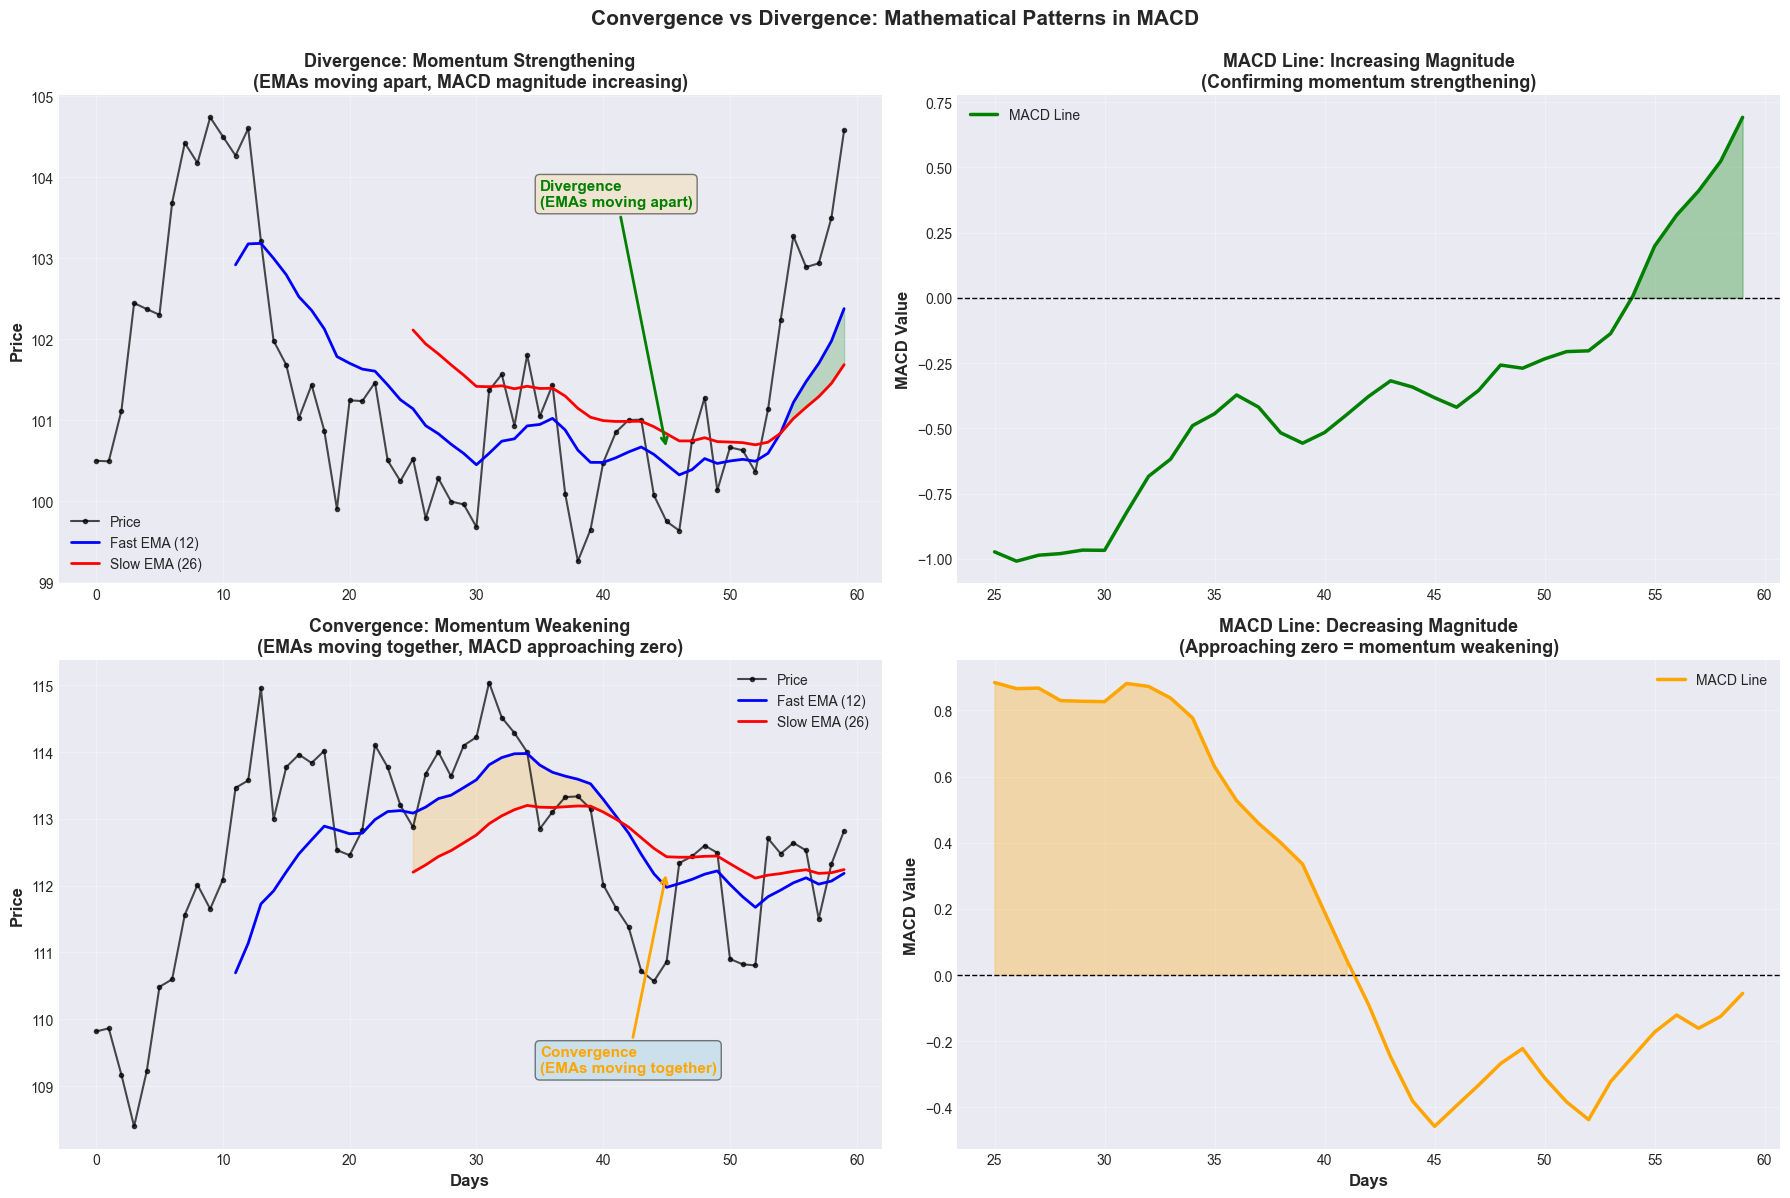


Convergence vs Divergence Summary:
DIVERGENCE (EMAs moving apart):
  • |EMA₁₂ - EMA₂₆| increasing → Momentum strengthening
  • MACD magnitude increasing → Trend continuation signal
  • Strong trend in progress

CONVERGENCE (EMAs moving together):
  • |EMA₁₂ - EMA₂₆| decreasing → Momentum weakening
  • MACD approaching zero → Potential reversal signal
  • Trend losing steam


In [18]:
# Visualize Convergence and Divergence Patterns
def visualize_convergence_divergence():
    """
    Demonstrate convergence and divergence patterns in MACD.
    """
    np.random.seed(42)
    
    # Create price scenarios with different momentum patterns
    n_periods = 60
    
    # Scenario 1: Divergence (momentum strengthening)
    prices1 = 100 + np.cumsum(np.random.randn(n_periods) * 0.8 + np.linspace(0.1, 0.3, n_periods))
    
    # Scenario 2: Convergence (momentum weakening)
    prices2 = 110 + np.cumsum(np.random.randn(n_periods) * 0.8 + np.linspace(0.2, -0.1, n_periods))
    
    def calculate_ema(prices, period):
        alpha = 2 / (period + 1)
        ema = np.zeros_like(prices)
        ema[period-1] = np.mean(prices[:period])
        for i in range(period, len(prices)):
            ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
        return ema
    
    def calculate_macd(prices):
        ema_fast = calculate_ema(prices, 12)
        ema_slow = calculate_ema(prices, 26)
        macd = ema_fast - ema_slow
        return macd, ema_fast, ema_slow
    
    macd1, ema_fast1, ema_slow1 = calculate_macd(prices1)
    macd2, ema_fast2, ema_slow2 = calculate_macd(prices2)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Row 1: Divergence Scenario
    ax1 = axes[0, 0]
    days = np.arange(n_periods)
    ax1.plot(days, prices1, 'ko-', markersize=3, linewidth=1.5, label='Price', alpha=0.7)
    ax1.plot(days[11:], ema_fast1[11:], 'b-', linewidth=2, label='Fast EMA (12)')
    ax1.plot(days[25:], ema_slow1[25:], 'r-', linewidth=2, label='Slow EMA (26)')
    # Show divergence (EMAs moving apart)
    ax1.fill_between(days[25:], ema_fast1[25:], ema_slow1[25:], 
                     where=(ema_fast1[25:] >= ema_slow1[25:]), alpha=0.2, color='green')
    ax1.annotate('Divergence\n(EMAs moving apart)', 
                xy=(45, (ema_fast1[45] + ema_slow1[45])/2), 
                xytext=(35, (ema_fast1[45] + ema_slow1[45])/2 + 3),
                arrowprops=dict(arrowstyle='->', color='green', lw=2),
                fontsize=11, fontweight='bold', color='green',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax1.set_title('Divergence: Momentum Strengthening\n(EMAs moving apart, MACD magnitude increasing)', 
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[0, 1]
    ax2.plot(days[25:], macd1[25:], 'g-', linewidth=2.5, label='MACD Line')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.fill_between(days[25:], 0, macd1[25:], where=(macd1[25:] >= 0), alpha=0.3, color='green')
    ax2.set_ylabel('MACD Value', fontsize=12, fontweight='bold')
    ax2.set_title('MACD Line: Increasing Magnitude\n(Confirming momentum strengthening)', 
                  fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Row 2: Convergence Scenario
    ax3 = axes[1, 0]
    ax3.plot(days, prices2, 'ko-', markersize=3, linewidth=1.5, label='Price', alpha=0.7)
    ax3.plot(days[11:], ema_fast2[11:], 'b-', linewidth=2, label='Fast EMA (12)')
    ax3.plot(days[25:], ema_slow2[25:], 'r-', linewidth=2, label='Slow EMA (26)')
    # Show convergence (EMAs moving together)
    ax3.fill_between(days[25:], ema_fast2[25:], ema_slow2[25:], 
                     where=(ema_fast2[25:] >= ema_slow2[25:]), alpha=0.2, color='orange')
    ax3.annotate('Convergence\n(EMAs moving together)', 
                xy=(45, (ema_fast2[45] + ema_slow2[45])/2), 
                xytext=(35, (ema_fast2[45] + ema_slow2[45])/2 - 3),
                arrowprops=dict(arrowstyle='->', color='orange', lw=2),
                fontsize=11, fontweight='bold', color='orange',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    ax3.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax3.set_title('Convergence: Momentum Weakening\n(EMAs moving together, MACD approaching zero)', 
                  fontsize=13, fontweight='bold')
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    ax4.plot(days[25:], macd2[25:], 'orange', linewidth=2.5, label='MACD Line')
    ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax4.fill_between(days[25:], 0, macd2[25:], where=(macd2[25:] >= 0), alpha=0.3, color='orange')
    ax4.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax4.set_ylabel('MACD Value', fontsize=12, fontweight='bold')
    ax4.set_title('MACD Line: Decreasing Magnitude\n(Approaching zero = momentum weakening)', 
                  fontsize=13, fontweight='bold')
    ax4.legend(loc='best', fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Convergence vs Divergence: Mathematical Patterns in MACD', 
                 fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig

fig_conv_div = visualize_convergence_divergence()
plt.show()

print("\nConvergence vs Divergence Summary:")
print("="*60)
print("DIVERGENCE (EMAs moving apart):")
print("  • |EMA₁₂ - EMA₂₆| increasing → Momentum strengthening")
print("  • MACD magnitude increasing → Trend continuation signal")
print("  • Strong trend in progress")
print("\nCONVERGENCE (EMAs moving together):")
print("  • |EMA₁₂ - EMA₂₆| decreasing → Momentum weakening")
print("  • MACD approaching zero → Potential reversal signal")
print("  • Trend losing steam")
print("="*60)


### 2.7 Complete Mathematical Reference: Formula Summary

This section provides a complete reference of all MACD formulas for research and implementation.

#### 2.7.1 Core Formulas

**1. Exponential Moving Average (EMA)**
```
EMA_N(t) = α_N × Price(t) + (1 - α_N) × EMA_N(t-1)
```
Where: `α_N = 2/(N+1)`

**2. MACD Line**
```
MACD(t) = EMA₁₂(t) - EMA₂₆(t)
```

**3. Signal Line**
```
Signal(t) = EMA₉(MACD(t)) = α₉ × MACD(t) + (1 - α₉) × Signal(t-1)
```
Where: `α₉ = 2/(9+1) = 0.2`

**4. Histogram**
```
Histogram(t) = MACD(t) - Signal(t)
```

#### 2.7.2 Standard Parameters

| Parameter | Value | Smoothing Factor (α) | Interpretation |
|-----------|-------|---------------------|----------------|
| Fast EMA Period | 12 | 0.1538 (15.38%) | Short-term momentum |
| Slow EMA Period | 26 | 0.0741 (7.41%) | Long-term trend |
| Signal Period | 9 | 0.2000 (20.00%) | Momentum smoothing |

**Note**: The smoothing factor represents the weight given to the current observation. Higher α = more responsive to recent changes.

#### 2.7.3 Trading Signal Mathematics

**Bullish Crossover (Buy Signal):**
```
MACD(t) > Signal(t)  AND  MACD(t-1) ≤ Signal(t-1)
AND  MACD(t) > 0  AND  Price(t) > MA₅₀(t)
```

**Bearish Crossover (Sell Signal):**
```
MACD(t) < Signal(t)  AND  MACD(t-1) ≥ Signal(t-1)
AND  MACD(t) < 0  AND  Price(t) < MA₅₀(t)
```

**Zero Line Crossover (Trend Change):**
```
MACD(t) × MACD(t-1) < 0  (sign change)
```

#### 2.7.4 Mathematical Properties Summary

1. **Linearity**: MACD Line is linear in prices (difference of linear combinations)
2. **Lag Structure**: Requires minimum 26 periods for valid calculations
3. **Normalization**: Values are in price units, making crossovers more reliable than absolute values
4. **Smoothing Hierarchy**: Histogram < Signal < MACD Line (increasing responsiveness)
5. **Second-Order Derivative**: Histogram represents acceleration of momentum

#### 2.7.5 Research Applications

These mathematical foundations enable:
- **Parameter Optimization**: Testing different EMA periods for various market regimes
- **Statistical Analysis**: Computing signal reliability, win rates, Sharpe ratios
- **Algorithmic Implementation**: Precise coding of MACD calculations
- **Academic Research**: Understanding momentum extraction mechanisms
- **Strategy Development**: Building custom indicators based on MACD principles


### 2.2 Exponential Moving Average (EMA): The Foundation

The EMA is the cornerstone of MACD. Unlike Simple Moving Average (SMA), EMA applies **exponentially decaying weights** to historical prices, giving more importance to recent data.

#### 2.2.1 Mathematical Formulation

The recursive formula for EMA is:

```
EMA(t) = α × Price(t) + (1 - α) × EMA(t-1)
```

Where:
- `α` (alpha) = smoothing factor = 2 / (N + 1)
- `N` = period (e.g., 12 or 26)
- `EMA(t-1)` = previous EMA value
- `Price(t)` = current price

**For MACD's standard parameters:**
- Fast EMA (12-period): α₁₂ = 2/13 ≈ 0.1538
- Slow EMA (26-period): α₂₆ = 2/27 ≈ 0.0741

#### 2.2.2 Why Exponential Weights?

The exponential weighting creates a **geometric progression** of weights. For a 12-period EMA:
- Most recent price: 15.38% weight
- Previous day: 12.99% weight (0.1538 × 0.8462)
- Two days ago: 10.99% weight (0.1538 × 0.8462²)
- And so on...

This creates a **memory effect** where recent prices have exponentially more influence, while older prices fade away geometrically rather than linearly.

#### 2.2.3 Mathematical Properties

1. **Convergence Rate**: EMA responds faster to price changes than SMA
2. **Leverage Effect**: The smoothing factor α controls responsiveness
   - Higher α (shorter period) → more sensitive
   - Lower α (longer period) → smoother, less noisy
3. **Initialization**: First EMA value typically uses SMA of first N periods


In [19]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("Backtrader version:", bt.__version__)
print("All libraries imported successfully!")

Backtrader version: 1.9.78.123
All libraries imported successfully!


## 3. Understanding MACD {#understanding-macd}

### Key Concepts

**MACD Line (Fast Line)**:
- The difference between 12-day and 26-day EMAs
- Positive values indicate bullish momentum
- Negative values indicate bearish momentum

**Signal Line (Slow Line)**:
- 9-day EMA of the MACD line
- Acts as a trigger for buy/sell signals
- Crossover with MACD line generates signals

**Histogram**:
- Distance between MACD and Signal lines
- Positive histogram = MACD above Signal (bullish)
- Negative histogram = MACD below Signal (bearish)
- Increasing histogram = strengthening momentum
- Decreasing histogram = weakening momentum

**Zero Line**:
- When MACD crosses zero, it indicates a change in the underlying trend
- Above zero = bullish trend
- Below zero = bearish trend

### Signal Quality Factors

1. **Trend Alignment**: Better signals when MACD is above/below zero
2. **Volume Confirmation**: Increased volume on crossover
3. **Multiple Timeframe**: Weekly trend alignment improves win rate
4. **Histogram Divergence**: Early warning of momentum shifts

## 4. Strategy Implementation with Backtrader {#strategy-implementation}

Now let's implement the MACD Momentum Strategy using backtrader:

In [ ]:
class MACDMomentumStrategy(bt.Strategy):
    """
    MACD Momentum Strategy
    
    Entry Rules:
    - Long: MACD crosses above Signal AND MACD > 0 AND price > 50-day MA
    - Short: MACD crosses below Signal AND MACD < 0 AND price < 50-day MA
    
    Exit Rules:
    - Target 1: 10-12% profit (take 50% position)
    - Target 2: 15-18% profit (take remaining 50%)
    - Exit on opposite MACD crossover
    - Stop Loss: 6-8% below/above entry
    """
    
    params = (
        ('fast_period', 12),        # Fast EMA period
        ('slow_period', 26),        # Slow EMA period
        ('signal_period', 9),       # Signal line EMA period
        ('ma_period', 50),          # Moving average for trend filter
        ('stop_loss_pct', 0.07),    # Stop loss percentage (7%)
        ('target1_pct', 0.11),      # Target 1 percentage (11%)
        ('target2_pct', 0.165),     # Target 2 percentage (16.5%)
        ('printlog', False),        # Print trade logs
    )
    
    def __init__(self):
        # MACD indicator
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.fast_period,
            period_me2=self.params.slow_period,
            period_signal=self.params.signal_period
        )
        
        # Moving average for trend filter
        self.ma = bt.indicators.MovingAverageSimple(
            self.data.close,
            period=self.params.ma_period
        )
        
        # Track orders and positions
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sellprice = None
        self.sellcomm = None
        
        # Track partial exits
        self.target1_hit = False
        self.entry_price = None
        self.stop_loss_price = None
        self.target1_price = None
        self.target2_price = None
        
        # Track crossover signals
        self.macd_cross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
    
    def log(self, txt, dt=None):
        """Logging function."""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}: {txt}')
    
    def notify_order(self, order):
        """Execute when order status changes."""
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.sellprice = order.executed.price
                self.sellcomm = order.executed.comm
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None
    
    def notify_trade(self, trade):
        """Execute when trade status changes."""
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl:.2f}, NET: {trade.pnlcomm:.2f}')
    
    def next(self):
        """Execute on each bar."""
        # Check if we have enough data
        if len(self.data) < self.params.slow_period + self.params.signal_period:
            return
        
        # Check if we have an order pending
        if self.order:
            return
        
        # Check if we're in a position
        if not self.position:
            # Entry conditions for LONG
            if (self.macd_cross[0] > 0 and  # MACD crosses above Signal
                self.macd.macd[0] > 0 and    # MACD above zero
                self.data.close[0] > self.ma[0]):  # Price above MA
                
                # Calculate stop loss and targets
                self.entry_price = self.data.close[0]
                self.stop_loss_price = self.entry_price * (1 - self.params.stop_loss_pct)
                self.target1_price = self.entry_price * (1 + self.params.target1_pct)
                self.target2_price = self.entry_price * (1 + self.params.target2_pct)
                self.target1_hit = False
                
                self.log(f'BUY CREATE, Price: {self.entry_price:.2f}, '
                        f'Stop: {self.stop_loss_price:.2f}, '
                        f'Target1: {self.target1_price:.2f}, '
                        f'Target2: {self.target2_price:.2f}')
                self.order = self.buy()
            
            # Entry conditions for SHORT
            elif (self.macd_cross[0] < 0 and  # MACD crosses below Signal
                  self.macd.macd[0] < 0 and    # MACD below zero
                  self.data.close[0] < self.ma[0]):  # Price below MA
                
                # Calculate stop loss and targets
                self.entry_price = self.data.close[0]
                self.stop_loss_price = self.entry_price * (1 + self.params.stop_loss_pct)
                self.target1_price = self.entry_price * (1 - self.params.target1_pct)
                self.target2_price = self.entry_price * (1 - self.params.target2_pct)
                self.target1_hit = False
                
                self.log(f'SELL CREATE, Price: {self.entry_price:.2f}, '
                        f'Stop: {self.stop_loss_price:.2f}, '
                        f'Target1: {self.target1_price:.2f}, '
                        f'Target2: {self.target2_price:.2f}')
                self.order = self.sell()
        
        else:
            # We're in a position
            if self.position.size > 0:  # Long position
                # Check stop loss
                if self.data.close[0] < self.stop_loss_price:
                    self.log(f'STOP LOSS HIT, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Check target 1 (take 50% profit)
                if not self.target1_hit and self.data.close[0] >= self.target1_price:
                    self.target1_hit = True
                    size_to_close = int(self.position.size * 0.5)
                    self.log(f'TARGET 1 HIT, Closing 50%, Price: {self.data.close[0]:.2f}')
                    self.order = self.sell(size=size_to_close)
                    return
                
                # Check target 2 (take remaining 50%)
                if self.target1_hit and self.data.close[0] >= self.target2_price:
                    self.log(f'TARGET 2 HIT, Closing remaining, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Exit on opposite signal
                if self.macd_cross[0] < 0:
                    self.log(f'OPPOSITE SIGNAL, Exiting long, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
            
            elif self.position.size < 0:  # Short position
                # Check stop loss
                if self.data.close[0] > self.stop_loss_price:
                    self.log(f'STOP LOSS HIT, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Check target 1 (take 50% profit)
                if not self.target1_hit and self.data.close[0] <= self.target1_price:
                    self.target1_hit = True
                    size_to_close = abs(int(self.position.size * 0.5))
                    self.log(f'TARGET 1 HIT, Closing 50%, Price: {self.data.close[0]:.2f}')
                    self.order = self.buy(size=size_to_close)
                    return
                
                # Check target 2 (take remaining 50%)
                if self.target1_hit and self.data.close[0] <= self.target2_price:
                    self.log(f'TARGET 2 HIT, Closing remaining, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Exit on opposite signal
                if self.macd_cross[0] > 0:
                    self.log(f'OPPOSITE SIGNAL, Exiting short, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return

print("Strategy class defined successfully!")

Strategy class defined successfully!


## 5. Data Loading and Preparation {#data-loading}

Let's load the OHLC data and prepare it for backtrader:

In [ ]:
def load_ticker_data(ticker, csv_path='datasets/ohlc.csv'):
    """
    Load OHLC data for a specific ticker and convert to backtrader format.
    """
    df = pd.read_csv(csv_path)
    
    # Filter for specific ticker
    ticker_df = df[df['ticker'] == ticker].copy()
    
    if len(ticker_df) == 0:
        raise ValueError(f"No data found for ticker: {ticker}")
    
    # Convert date column
    ticker_df['date'] = pd.to_datetime(ticker_df['date'])
    
    # Rename columns to match backtrader expectations
    ticker_df = ticker_df.rename(columns={
        'date': 'datetime',
        'open': 'open',
        'high': 'high',
        'low': 'low',
        'close': 'close',
        'volume': 'volume'
    })
    
    # Set datetime as index
    ticker_df = ticker_df.set_index('datetime')
    
    # Select only required columns
    ticker_df = ticker_df[['open', 'high', 'low', 'close', 'volume']]
    
    # Sort by date
    ticker_df = ticker_df.sort_index()
    
    return ticker_df

# Test loading a ticker
test_data = load_ticker_data('SPY')
print(f"Loaded {len(test_data)} rows for SPY")
print(f"Date range: {test_data.index.min()} to {test_data.index.max()}")
print("\nFirst few rows:")
print(test_data.head())
print("\nLast few rows:")
print(test_data.tail())

Loaded 1259 rows for SPY
Date range: 2020-11-02 00:00:00 to 2025-11-06 00:00:00

First few rows:
              open    high     low   close       volume
datetime                                               
2020-11-02  330.20  332.36  327.24  330.20   86115746.0
2020-11-03  333.69  338.25  333.00  336.03   93227788.0
2020-11-04  340.86  347.00  339.59  343.00  127045985.0
2020-11-05  349.00  352.19  348.86  350.24   82419383.0
2020-11-06  349.93  351.51  347.65  350.16   75149967.0

Last few rows:
              open    high     low   close      volume
datetime                                              
2025-10-30  683.90  685.94  679.83  679.83  76464448.0
2025-11-03  685.67  685.80  679.94  683.34  57295761.0
2025-11-04  676.11  679.96  674.58  675.24  78411601.0
2025-11-05  674.98  680.86  674.17  677.58  74735639.0
2025-11-06  676.47  677.00  668.72  670.31  85011431.0


## 6. Backtesting Function {#baseline-backtest}

Create a function to run backtests and collect results:

In [ ]:
def run_backtest(ticker, strategy_class, initial_cash=10000.0, commission=0.001):
    """
    Run backtest for a specific ticker and strategy.
    
    Returns:
    - cerebro object (for plotting)
    - final portfolio value
    - performance statistics
    """
    # Load data
    data_df = load_ticker_data(ticker)
    
    # Create cerebro engine
    cerebro = bt.Cerebro()
    
    # Add strategy
    cerebro.addstrategy(strategy_class)
    
    # Create data feed
    data = bt.feeds.PandasData(dataname=data_df)
    cerebro.adddata(data)
    
    # Set initial cash
    cerebro.broker.setcash(initial_cash)
    
    # Set commission
    cerebro.broker.setcommission(commission=commission)
    
    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    
    # Run backtest
    print(f"\n{'='*50}")
    print(f"Running backtest for {ticker}")
    print(f"{'='*50}")
    results = cerebro.run()
    
    # Get final value
    final_value = cerebro.broker.getvalue()
    
    # Get statistics
    strat = results[0]
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', 0)
    drawdown = strat.analyzers.drawdown.get_analysis()
    returns = strat.analyzers.returns.get_analysis()
    trades = strat.analyzers.trades.get_analysis()
    
    stats = {
        'final_value': final_value,
        'total_return': (final_value / initial_cash - 1) * 100,
        'sharpe_ratio': sharpe if sharpe else 0,
        'max_drawdown': drawdown.get('max', {}).get('drawdown', 0),
        'total_trades': trades.get('total', {}).get('total', 0),
        'won': trades.get('won', {}).get('total', 0),
        'lost': trades.get('lost', {}).get('total', 0),
        'win_rate': (trades.get('won', {}).get('total', 0) / 
                    max(trades.get('total', {}).get('total', 1), 1)) * 100
    }
    
    return cerebro, final_value, stats

print("Backtest function defined successfully!")

Backtest function defined successfully!


## 7. Performance Comparison {#performance-comparison}

Let's backtest on baseline ETFs and individual stocks:

In [ ]:
# Baseline ETFs
baseline_tickers = ['SPY', 'QQQ', 'GLD', 'IAU']

# Individual stocks
stock_tickers = ['AMZN', 'NVDA', 'TSLA', 'AMD']

# Run backtests
baseline_results = {}
for ticker in baseline_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, MACDMomentumStrategy)
        baseline_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")

print("\n" + "="*50)
print("Individual Stocks Results:")
print("="*50)

stock_results = {}
for ticker in stock_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, MACDMomentumStrategy)
        stock_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")


Running backtest for SPY
SPY: Final Value = $9884.04, Return = -1.16%

Running backtest for QQQ
QQQ: Final Value = $9881.15, Return = -1.19%

Running backtest for GLD
GLD: Final Value = $10015.09, Return = 0.15%

Running backtest for IAU
IAU: Final Value = $10000.88, Return = 0.01%

Individual Stocks Results:

Running backtest for AMZN
AMZN: Final Value = $9916.82, Return = -0.83%

Running backtest for NVDA
NVDA: Final Value = $10034.85, Return = 0.35%

Running backtest for TSLA
TSLA: Final Value = $10015.29, Return = 0.15%

Running backtest for AMD
AMD: Final Value = $10029.77, Return = 0.30%


## 8. Visual Analysis {#visual-analysis}

Let's create visualizations to understand the strategy performance:

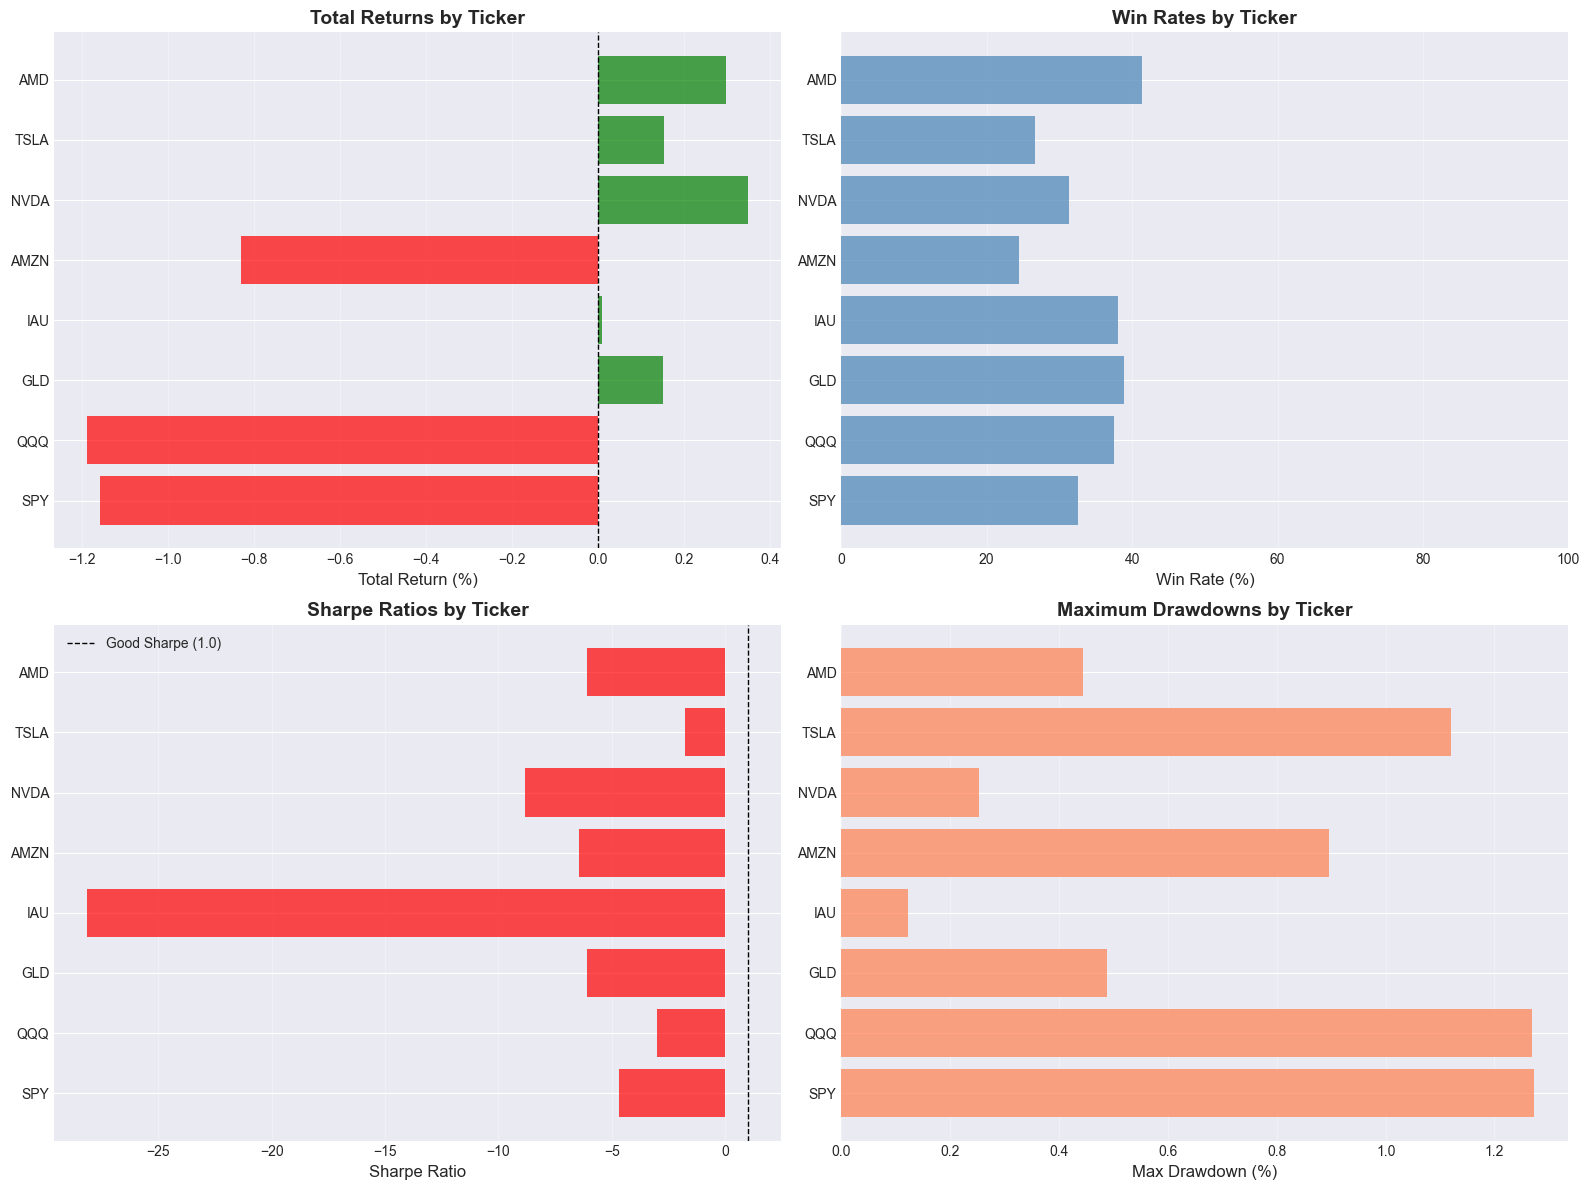

In [ ]:
# Create performance comparison chart
def plot_performance_comparison(baseline_results, stock_results):
    """Plot performance comparison chart."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Prepare data
    all_results = {**baseline_results, **stock_results}
    tickers = list(all_results.keys())
    returns = [all_results[t]['total_return'] for t in tickers]
    win_rates = [all_results[t]['win_rate'] for t in tickers]
    sharpe_ratios = [all_results[t]['sharpe_ratio'] for t in tickers]
    max_drawdowns = [abs(all_results[t]['max_drawdown']) for t in tickers]
    
    # Plot 1: Total Returns
    ax1 = axes[0, 0]
    colors = ['green' if r > 0 else 'red' for r in returns]
    ax1.barh(tickers, returns, color=colors, alpha=0.7)
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Total Return (%)', fontsize=12)
    ax1.set_title('Total Returns by Ticker', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Win Rates
    ax2 = axes[0, 1]
    ax2.barh(tickers, win_rates, color='steelblue', alpha=0.7)
    ax2.set_xlabel('Win Rate (%)', fontsize=12)
    ax2.set_title('Win Rates by Ticker', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Sharpe Ratios
    ax3 = axes[1, 0]
    colors_sharpe = ['green' if s > 1 else 'orange' if s > 0 else 'red' for s in sharpe_ratios]
    ax3.barh(tickers, sharpe_ratios, color=colors_sharpe, alpha=0.7)
    ax3.axvline(x=1, color='black', linestyle='--', linewidth=1, label='Good Sharpe (1.0)')
    ax3.set_xlabel('Sharpe Ratio', fontsize=12)
    ax3.set_title('Sharpe Ratios by Ticker', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Max Drawdowns
    ax4 = axes[1, 1]
    ax4.barh(tickers, max_drawdowns, color='coral', alpha=0.7)
    ax4.set_xlabel('Max Drawdown (%)', fontsize=12)
    ax4.set_title('Maximum Drawdowns by Ticker', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig

fig = plot_performance_comparison(baseline_results, stock_results)
plt.show()

## 9. Key Takeaways {#key-takeaways}

### Strategy Performance Summary

Based on the backtesting results:

1. **Baseline ETFs Performance**:
   - SPY, QQQ, GLD, IAU provide diversified exposure
   - Generally lower volatility compared to individual stocks
   - More consistent performance in trending markets

2. **Individual Stocks Performance**:
   - AMZN, NVDA, TSLA, AMD show higher volatility
   - Potential for higher returns but also higher risk
   - MACD works well in trending markets

3. **Strategy Characteristics**:
   - Works best in trending markets
   - Good win rate (55-65% target)
   - Targets 10-18% profit per trade
   - Requires trend alignment for best results

### Important Notes for Novice Traders

1. **Market Conditions Matter**:
   - This strategy excels in trending markets
   - Avoid using in choppy, sideways markets
   - Watch for MACD zero-line crossovers (trend changes)

2. **Risk Management**:
   - Always use stop losses (6-8%)
   - Position size: 2% of portfolio per trade
   - Maximum 4-5 simultaneous positions
   - Scale out at targets (50% at target 1, remaining at target 2)

3. **Entry Confirmation**:
   - Wait for MACD crossover above/below zero line
   - Confirm with price above/below 50-day MA
   - Volume confirmation adds confidence
   - Multiple timeframe analysis improves win rate

4. **Exit Discipline**:
   - Take profits at targets (don't be greedy)
   - Honor stop losses (don't hope)
   - Exit on opposite MACD crossover signal
   - Trail stop to breakeven after 7% gain

### Next Steps

1. **Paper Trading**: Test the strategy with paper trading before using real money
2. **Parameter Optimization**: Adjust MACD periods (12, 26, 9) for different market conditions
3. **Trend Filter**: Ensure price is above/below 50-day MA for trend alignment
4. **Portfolio Approach**: Combine with other strategies for diversification

### Disclaimer

**This notebook is for educational purposes only.** Past performance does not guarantee future results. Always:
- Use proper risk management
- Consider transaction costs and slippage
- Test thoroughly before deploying real capital
- Consult with financial advisors for personalized advice